In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import rpy2
import nltk
import urllib.request

import cv2

In [2]:
# Read in the data for the 'books' listings, and the 'ratings'
#   downloaded directly from github.
# I force the isbn and isbn13 to be read in as strings in an attempt
#   to not lose the zero padding if it is contained in the string to
#   begin with.
books = pd.read_csv("good_reads_data/books.csv", delimiter=",", dtype={'isbn': 'str', 'isbn13': 'str'})
ratings = pd.read_csv("good_reads_data/ratings.csv", delimiter=",")

In [3]:
# Because we want to work with cover data, we want to remove all books
#    that do not have an easily accessible cover
# Here we simply loop through the row, and if the book cover is the default
#    good reads no cover image, we add it to a list of excluded ids
excluded_ids = []

for jj, book in books.iterrows():
    if book["image_url"] == "https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png":
        excluded_ids.append(book["book_id"])

In [4]:
# Here we re-define the dataframes to not include the excluded ids
books = books[~books["book_id"].isin(excluded_ids)]
ratings = ratings[~ratings["book_id"].isin(excluded_ids)]

In [5]:
# This loops through all of the books in the dataframe, and saves them as a constant size (50,75)
# Open URL
for ii, book in books.iterrows():
    if ii % 500 == 0:
        print(ii)

    with urllib.request.urlopen(book["image_url"]) as url:
        img_array = np.array(bytearray(url.read()), dtype=np.uint8)
        img = cv2.imdecode(img_array, -1)
        cv2.imwrite("good_reads_data/constant_size/"+str(book["book_id"])+".jpg", cv2.resize(img, (50,75)))

In [6]:
# Here we import the required libraries for a VAE in keras
#   and construct it 
import h5py

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import metrics

# Constants defined 
epsilon_std = 1.0 # STD for the resampling trick 
im_h = 75 # Image Height
im_w = 50 # Image Width
im_ch = 3 # Number of Channels (3 for Colour Image)
latent = 5 # The size of the latent space
features = 16 # The features used in the VAE for each dense layer
beta = 1 # The Beta for the simple Beta-VAE loss function

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

def Encoder(im_h=75, im_w=50, im_ch=3, latent=5, features=16):
    im_input = Input(shape=(im_h, im_w, im_ch))
    C1 = Conv2D(features, 3, padding='same', activation='relu')(im_input)
    C2 = Conv2D(features, 3, padding='same', activation='relu')(C1)
    C2 = Conv2D(features, 3, padding='same', activation='relu')(C2)
    C2 = Conv2D(features, 3, padding='same', activation='relu')(C2)
    flat = Flatten()(C2)
    H1 = Dense(64, activation='relu')(flat)

    z_mean = Dense(latent)(H1)
    z_log_sd = Dense(latent)(H1)
  
    z = Lambda(sampling)([z_mean, z_log_sd])

    return Model(im_input, [z, z_mean, z_log_sd])

def Decoder(im_h=75, im_w=50, latent=5, features=16):
    latent_input = Input(shape=(latent,))
    H1 = Dense(features*im_h*im_w)(latent_input)
    square = Reshape((im_h, im_w, features))(H1)
    C1 = Conv2DTranspose(features, 3, padding='same', activation='relu')(square)
    C1 = Conv2DTranspose(features, 3, padding='same', activation='relu')(square)
    C1 = Conv2DTranspose(features, 3, padding='same', activation='relu')(square)
    C2 = Conv2DTranspose(im_ch, 3, padding='same', activation='sigmoid')(C1)

    return Model(latent_input, C2)

# Initialize the Models
EncoderModel = Encoder(im_h, im_w, im_ch, latent, features)
DecoderModel = Decoder(im_h, im_w, latent, features)

Im_In = Input(shape=(im_h, im_w, im_ch))
Encoded, z_mean, z_log_sd = EncoderModel(Im_In)
Im_Out = DecoderModel(Encoded)

# Variational Autoencoder
VAE = Model(Im_In, Im_Out)

xent_loss = im_h * im_w * metrics.binary_crossentropy(
            K.flatten(Im_In),
            K.flatten(Im_Out))
kl_loss = - 0.5 * K.sum(1 + z_log_sd - K.square(z_mean) - K.exp(z_log_sd), axis=-1)
vae_loss = K.mean(xent_loss + beta*kl_loss)
VAE.add_loss(vae_loss)

VAE.compile(optimizer='adam', loss=None)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/dylan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Output "model_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_2" during training.


In [7]:
VAE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              [(None, 5), (None, 5), (N 3848122   
_________________________________________________________________
model_2 (Model)              (None, 75, 50, 3)         362755    
Total params: 4,210,877
Trainable params: 4,210,877
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Here we load all of the images, and convert to a [0,1] numpy array for easier processing in the network
tr_images = [cv2.imread("good_reads_data/constant_size/"+str(ii)+".jpg") for ii in books["book_id"]]
tr_images = np.array(tr_images, dtype=np.float16)/255.

In [10]:
# This is the training step/weight loading step; 
# Change 'if False' to 'if True' if you want to train the VAE
if False:
    filepath="Checkpoint_training_big_5_no_beta.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
    earlystop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, verbose=1)
    callback_list = [checkpoint, earlystop]


    VAE.fit(tr_images, shuffle=True, verbose=1, epochs=200, batch_size=32, callbacks=callback_list)
    VAE.save_weights("big_5_no_beta.h5")
else:
    VAE.load_weights("big_5_no_beta.h5")

In [11]:
# Generate predictions for the first 100 images
predicts = VAE.predict(tr_images[0:100])

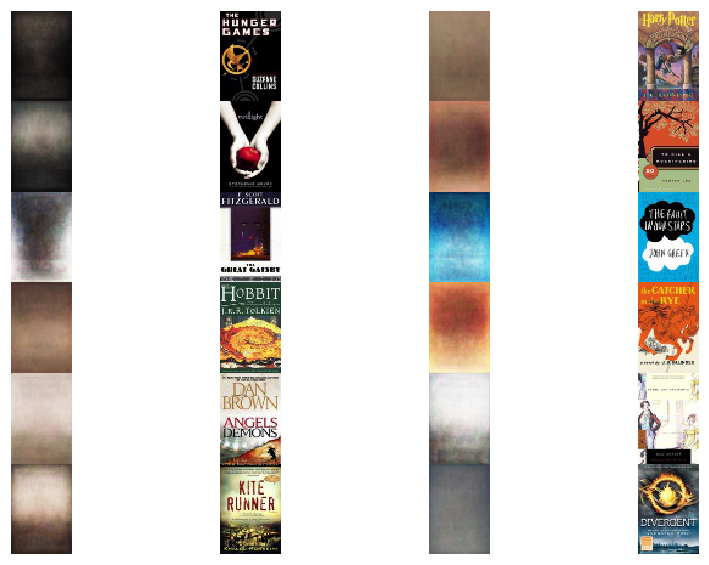

In [12]:
# Visualize how well the VAE performs
plt.figure(figsize = (15,10))
gs1 = gridspec.GridSpec(6, 4)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

for i in range(24):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    if (i%2 == 0):
        ax1.imshow(cv2.cvtColor(predicts[i//2], cv2.COLOR_BGR2RGB))
    else:
        ax1.imshow(cv2.cvtColor(tr_images[i//2].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
# Predict the latent embeddings/re-projections
encoded_ims = EncoderModel.predict(tr_images[0:100])
decoded_ims = DecoderModel.predict(encoded_ims[1])

In [15]:
encoded_ims[1][5]

array([ 0.76682603, -0.36874533,  2.3321257 , -0.842216  , -0.35456967],
      dtype=float32)

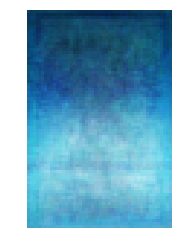

In [16]:
plt.imshow(cv2.cvtColor(decoded_ims[5].astype('float32'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()